In [1]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.signal import medfilt
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/swot/SUM02/takaya/SOCCOM/SIO'

In [3]:
pf = pd.read_csv(op.join(ddir,'../Fronts/pf.txt'), delim_whitespace=True, 
                 nrows=968, header=None, dtype=float, names=['lon','lat'])
saf = pd.read_csv(op.join(ddir,'../Fronts/saf.txt'), delim_whitespace=True, 
                 nrows=1079, header=None, dtype=float, names=['lon','lat'])

In [4]:
ds = xr.open_dataset(op.join(ddir,'5904185_Mprof.nc'))
ds

<xarray.Dataset>
Dimensions:                          (N_CALIB: 1, N_HISTORY: 0, N_LEVELS: 497, N_PARAM: 6, N_PROF: 398)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                        object ...
    FORMAT_VERSION                   object ...
    HANDBOOK_VERSION                 object ...
    REFERENCE_DATE_TIME              object ...
    DATE_CREATION                    object ...
    DATE_UPDATE                      object ...
    PLATFORM_NUMBER                  (N_PROF) object ...
    PROJECT_NAME                     (N_PROF) object ...
    PI_NAME                          (N_PROF) object ...
    STATION_PARAMETERS               (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                     (N_PROF) float64 ...
    DIRECTION                        (N_PROF) object ...
    DATA_CENTRE                      (N_PROF) object ...
    DC_REFERENCE                     (N_PROF) object ...
    DATA_STATE_INDICATOR       

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Series.data is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


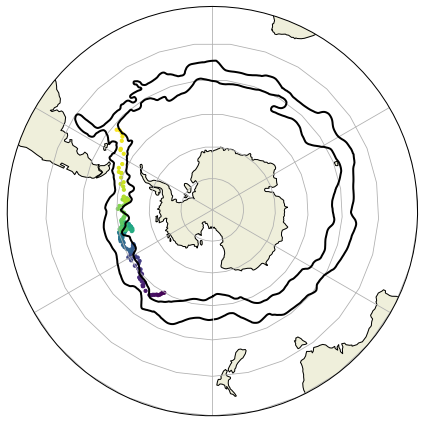

In [7]:
fig = plt.figure(figsize=(6,6))
fig.set_tight_layout(True)
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
im = ax.scatter(ds.groupby('JULD').mean().LONGITUDE.values, ds.groupby('JULD').mean().LATITUDE.values, 
               s=10., c=ds.groupby('JULD').mean().JULD.values, rasterized=True,
               transform=ccrs.PlateCarree())
ax.plot(pf.lon.data, (pf.lat-1.).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax.plot(saf.lon.data, (saf.lat+1.).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

In [8]:
pnew = np.append(np.arange(4,100,4),np.arange(100,510,10))

lat = ds.LATITUDE
lon = ds.LONGITUDE
p = ds.PRES_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PRES_ADJUSTED_QC,dtype=float),
                                                                     0.),3.),4.),6.),7.), 
                                        dims=ds.PRES_ADJUSTED_QC.dims, coords=ds.PRES_ADJUSTED_QC.coords)<9.)
p = np.ma.masked_invalid(p.where(p!=99999.).where(p>0.))
maskp = p.mask
            
t = ds.TEMP_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.TEMP_ADJUSTED_QC,dtype=float),
                                                                     0.),3.),4.),6.),7.), 
                                        dims=ds.TEMP_ADJUSTED_QC.dims, coords=ds.TEMP_ADJUSTED_QC.coords)<9.)
t = t.where(t!=99999.)
s = ds.PSAL_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PSAL_ADJUSTED_QC,dtype=float),
                                                                     0.),3.),4.),6.),7.), 
                                        dims=ds.PSAL_ADJUSTED_QC.dims, coords=ds.PSAL_ADJUSTED_QC.coords)<9.)
s = s.where(s!=99999.).where(s>0.)
SA = xr.apply_ufunc(gsw.SA_from_SP,s,p,lon,lat)
pt = xr.apply_ufunc(gsw.pt0_from_t,SA,t,p)
CT = xr.apply_ufunc(gsw.CT_from_pt,SA,pt)
rho = np.ma.masked_invalid(xr.apply_ufunc(gsw.rho,SA,CT,0))
maskr = rho.mask
n2, pN2 = gsw.Nsquared(SA.data,CT.data,p.data,lat=lat.data[:,np.newaxis],axis=1)
n2 = np.ma.masked_invalid(n2)
maskN = n2.mask

bp700 = ds.BBP700.where(xr.DataArray(maval(maval(maval(maval(np.asarray(ds.BBP700_QC,dtype=float),
                                                            0.),4.),6.),7.), 
                                    dims=ds.BBP700_QC.dims, coords=ds.BBP700_QC.coords)<9.
                         ).where(ds.BBP700!=99999.)
chl = ds.CHLA_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.CHLA_ADJUSTED_QC,dtype=float),
                                                                        0.),3.),4.),6.),7.), 
                                        dims=ds.CHLA_ADJUSTED_QC.dims, coords=ds.CHLA_ADJUSTED_QC.coords)<9.
                              ).where(ds.CHLA_ADJUSTED!=99999.)
if np.nanmax(p)>6e2:
    chl -= np.nanmedian(chl.where(p>=600))
    bp700 -= np.nanmedian(bp700.where(p>=600))
bp700 = bp700.where(bp700>0.)
chl = chl.where(chl>0.)
bpmed = bp700.copy()
chmed = chl.copy()
for i in range(len(ds.N_PROF)):
    bpmed[i] = medfilt(bp700[i], 5)
    chmed[i] = medfilt(chl[i], 5)
            
bp470 = bpmed * (470/700)**-.78
Cphyto = np.ma.masked_invalid(12128*bp470 + .59)
maskC = Cphyto.mask 
bpmed = np.ma.masked_array(bpmed, mask=maskC)
chmed = np.ma.masked_invalid(chmed)
maskc = chmed.mask

pMLD = np.empty(len(ds.N_PROF))
Chl = np.empty((len(ds.N_PROF),len(pnew)))
Rho = np.empty((len(ds.N_PROF),len(pnew)))
N2 = np.empty((len(ds.N_PROF),len(pnew)))
C = np.empty((len(ds.N_PROF),len(pnew)))
bp = np.empty((len(ds.N_PROF),len(pnew)))

for i in range(len(ds.N_PROF)):
    if len(chmed[i].compressed()) > 0.:
        func1 = pchip(np.ma.masked_array(p,maskc)[i].compressed(),
                     np.ma.masked_array(chmed,maskp)[i].compressed(),extrapolate=False)
        Chl[i] = func1(pnew)
    else:
        Chl[i] = np.ones(len(pnew))*np.nan
        
    if len(rho[i].compressed()) > 1:
        for j in range(len(ds.N_LEVELS)):
            if ~np.isnan(rho.data[i,j]):
                top = j
                break
        if p[i,top]<=2e1:
            itop = int(np.argmin(np.abs(p[i]-10.)))
            if ~np.isnan(rho[i,itop]):
                pMLD[i] = p[i,itop+np.nanargmin(np.abs((rho[i,itop:]-rho[i,itop])-0.03))]
            else:
                pMLD[i] = np.nan
        else:
            pMLD[i] = np.nan
        func2 = pchip(np.ma.masked_array(p,maskr)[i].compressed(),
                     np.ma.masked_array(rho,maskp)[i].compressed(),extrapolate=False)
        Rho[i] = func2(pnew)
    else:
        pMLD[i] = np.nan
        Rho[i] = np.ones(len(pnew))*np.nan
            
    if len(Cphyto[i].compressed()) > 0.:
        func3 = pchip(np.ma.masked_array(p,maskC)[i].compressed(),
                     np.ma.masked_array(Cphyto,maskp)[i].compressed(),extrapolate=False)
        C[i] = func3(pnew)
    else:
        C[i] = np.ones(len(pnew))*np.nan
            
    if len(bpmed[i].compressed()) > 0.:
        func4 = pchip(np.ma.masked_array(p,maskC)[i].compressed(),
                     np.ma.masked_array(bpmed,maskp)[i].compressed(),extrapolate=False)
        bp[i] = func4(pnew)
    else:
        bp[i] = np.ones(len(pnew))*np.nan
        
    if len(n2[i].compressed()) > 0.:
        func4 = pchip(np.ma.masked_array(pN2,maskN)[i].compressed(),
                     n2[i].compressed(),extrapolate=False)
        N2[i] = func4(pnew)
    else:
        N2[i] = np.ones(len(pnew))*np.nan
        
dC = np.abs(np.diff(C,axis=-1)/np.diff(pnew))
for i in range(C.shape[0]):
    pcrit = np.nanmax(np.array([1e2,pMLD[i]]))
    for j in range(C.shape[1]-1):
        if pnew[j] > pcrit and dC[i,j]>1.:
            C[i,j+1] = np.nan
C = np.ma.masked_invalid(C)
maskC = C.mask
bp = np.ma.masked_array(bp, maskC)
                            
chl_test = xr.DataArray(Chl, dims=['time','pres'],
                       coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                              'lat':('time',lat),'lon':('time',lon)}
                       ).dropna('time', how='all')
C_test = xr.DataArray(C, dims=['time','pres'], 
                     coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                            'lat':('time',lat),'lon':('time',lon)}
                     ).dropna('time', how='all')
bp_test = xr.DataArray(bp, dims=['time','pres'], 
                      coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                             'lat':('time',lat),'lon':('time',lon)}
                      ).dropna('time', how='all')
rho_test = xr.DataArray(Rho, dims=['time','pres'],
                       coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                              'lat':('time',lat),'lon':('time',lon)}
                       ).dropna('time', how='all')
N2_test = xr.DataArray(N2, dims=['time','pres'],
                      coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                             'lat':('time',lat),'lon':('time',lon)}
                      ).dropna('time', how='all')
pMLD_test = xr.DataArray(pMLD, dims=['time'], 
                        coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),
                               'lat':('time',lat),'lon':('time',lon)}
                        ).dropna('time', how='all')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater_equal
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal


In [9]:
rho_dropped = rho_test.drop('lat').drop('lon').groupby('time').first()
N2_dropped = N2_test.drop('lat').drop('lon').groupby('time').first()
pML_dropped = pMLD_test.drop('lat').drop('lon').groupby('time').first()
C_dropped = C_test.groupby('time').first()

dt_intp = ds.JULD.diff('N_PROF')
dt_intp = int(np.asarray(dt_intp.where(dt_intp>np.timedelta64(0)).min(),dtype=float)/(86400*1e9))
if dt_intp == 0:
    dt_intp = 1

tnew = np.arange(np.asarray(rho_test.time,dtype='datetime64[D]')[0]+np.timedelta64(12,'h'), 
                np.asarray(rho_test.time,dtype='datetime64[D]')[-1]+np.timedelta64(24,'h'), 
                np.timedelta64(dt_intp,'D'),
                dtype='datetime64')
C_intp = C_dropped.interp(time=tnew, method='linear')
chl_intp = chl_test.interp(time=tnew, method='linear')
bp_intp = bp_test.interp(time=tnew, method='linear')
rho_intp = rho_dropped.interp(time=tnew, method='linear')
N2_intp = N2_dropped.interp(time=tnew, method='linear')
pML_intp = pML_dropped.interp(time=tnew, method='linear').where(~np.isnan(rho_intp[:,5]))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


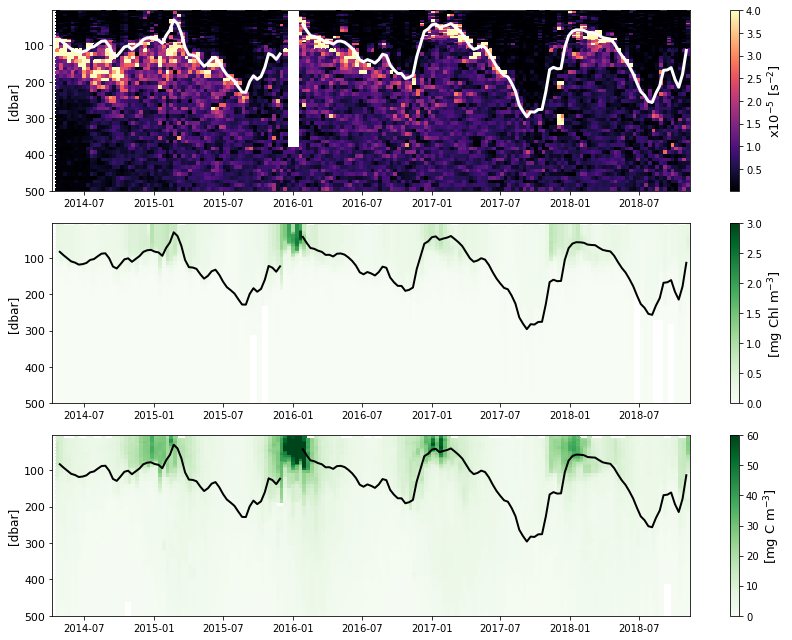

In [10]:
import matplotlib as mpl

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12,9))
fig.set_tight_layout(True)
im1 = ax1.pcolormesh(N2_intp.time, -pnew, N2_intp.data.T*1e5, 
                    vmin=1e-2, vmax=4e0, cmap='magma')
im2 = ax2.pcolormesh(chl_intp.time, -pnew, chl_intp.data.T, 
                     vmin=0., vmax=3., cmap='Greens')
im3 = ax3.pcolormesh(C_intp.time, -pnew, C_intp.data.T,
                     vmin=0., vmax=60, cmap='Greens')

ax1.plot(pML_intp.time, -pML_intp.rolling(time=3, center=True).mean(), c='w', lw=3)
ax2.plot(pML_intp.time, -pML_intp.rolling(time=3, center=True).mean(), 'k', lw=2)
ax3.plot(pML_intp.time, -pML_intp.rolling(time=3, center=True).mean(), 'k', lw=2)

ax1.set_yticks([-100,-200,-300,-400,-500])
ax2.set_yticks([-100,-200,-300,-400,-500])
ax3.set_yticks([-100,-200,-300,-400,-500])
ax1.set_yticklabels([100,200,300,400,500], fontsize=11)
ax2.set_yticklabels([100,200,300,400,500], fontsize=11)
ax3.set_yticklabels([100,200,300,400,500], fontsize=11)

ax1.set_ylabel(r"[dbar]", fontsize=12)
ax2.set_ylabel(r"[dbar]", fontsize=12)
ax3.set_ylabel(r"[dbar]", fontsize=12)

cb1 = fig.colorbar(im1, ax=ax1, ticks=[.5,1,1.5,2,2.5,3,3.5,4])
cb2 = fig.colorbar(im2, ax=ax2)
cb3 = fig.colorbar(im3, ax=ax3)

cb1.set_label(r"x10$^{-5}$ [s$^{-2}$]", fontsize=13)
cb2.set_label(r"[mg Chl m$^{-3}$]", fontsize=13)
cb3.set_label(r"[mg C m$^{-3}$]", fontsize=13)

# plt.savefig(op.join(ddir,'../Figures/SOCCOM_4185_N2-chl-C.pdf'))

In [11]:
dp = np.diff(pnew)[:24]
dp = np.append(dp, 7)
dp = np.append(dp, np.diff(pnew[24:]))

In [12]:
dt = C_test.time.diff('time')
dt = dt.where(dt>np.timedelta64(30,'D'))
dtC = np.empty(0, dtype='datetime64')
for i in range(len(dt)):
    if dt.data[i].astype(np.timedelta64) != np.timedelta64('NaT'):
        dtC = np.append(dtC, np.asarray([dt.time.data[i-1], dt.time.data[i]], dtype='datetime64'))
dt = rho_test.time.diff('time')
dt = dt.where(dt>np.timedelta64(30,'D'))
dtR = np.empty(0, dtype='datetime64')
for i in range(len(dt)):
    if dt.data[i].astype(np.timedelta64) != np.timedelta64('NaT'):
        dtR = np.append(dtR, np.asarray([dt.time.data[i-1], dt.time.data[i]], dtype='datetime64'))

if len(dtC)>0:
    if len(dtC)==2:
        C_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
        chl_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
        bp_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
    elif len(dtC)==4:
        C_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
        C_intp.sel(time=slice(dtC[2],dtC[3]))[:] = np.nan
        chl_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
        chl_intp.sel(time=slice(dtC[2],dtC[3]))[:] = np.nan
        bp_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
        bp_intp.sel(time=slice(dtC[2],dtC[3]))[:] = np.nan
    elif len(dtC)==6:
        C_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
        C_intp.sel(time=slice(dtC[2],dtC[3]))[:] = np.nan
        C_intp.sel(time=slice(dtC[4],dtC[5]))[:] = np.nan
        chl_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
        chl_intp.sel(time=slice(dtC[2],dtC[3]))[:] = np.nan
        chl_intp.sel(time=slice(dtC[4],dtC[5]))[:] = np.nan
        bp_intp.sel(time=slice(dtC[0],dtC[1]))[:] = np.nan
        bp_intp.sel(time=slice(dtC[2],dtC[3]))[:] = np.nan
        bp_intp.sel(time=slice(dtC[4],dtC[5]))[:] = np.nan
    else:
        C_intp[:] = np.nan
        chl_intp[:] = np.nan
        bp_intp[:] = np.nan
        
if len(dtR)>0:
    if len(dtR)==2:
        rho_intp.sel(time=slice(dtR[0],dtR[1]))[:] = np.nan
        pML_intp.sel(time=slice(dtR[0],dtR[1]))[:] = np.nan
    elif len(dtR)==4:
        rho_intp.sel(time=slice(dtR[0],dtR[1]))[:] = np.nan
        rho_intp.sel(time=slice(dtR[2],dtR[3]))[:] = np.nan
        pML_intp.sel(time=slice(dtR[0],dtR[1]))[:] = np.nan
        pML_intp.sel(time=slice(dtR[2],dtR[3]))[:] = np.nan
    elif len(dtR)==6:
        rho_intp.sel(time=slice(dtR[0],dtR[1]))[:] = np.nan
        rho_intp.sel(time=slice(dtR[2],dtR[3]))[:] = np.nan
        rho_intp.sel(time=slice(dtR[4],dtR[5]))[:] = np.nan
        pML_intp.sel(time=slice(dtR[0],dtR[1]))[:] = np.nan
        pML_intp.sel(time=slice(dtR[2],dtR[3]))[:] = np.nan
        pML_intp.sel(time=slice(dtR[4],dtR[5]))[:] = np.nan
    else:
        rho_intp[:] = np.nan
        pML_intp[:] = np.nan

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: In the future, NAT != NAT will be True rather than False.
  """
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: In the future, NAT != NAT will be True rather than False.
  # This is added back by InteractiveShellApp.init_path()


In [13]:
Cml = C_test[:,0].copy()
Cml[:] = np.nan
Chlml = chl_test[:,0].copy()
Chlml[:] = np.nan
ChlsML = Chlml.copy()
ChlH = Chlml.copy()
Cintg = Cml.copy()
CintgH = Cml.copy()
i = 0
for tt in C_test.time.data:
    CintgH[i] = np.nansum(C_test.sel(time=tt)*dp)
    ChlH[i] = np.nansum(chl_test.sel(time=tt)*dp)
    if tt in pML_dropped.time.data:
#         print(tt)
        Cml[i] = np.nansum(C_test.sel(time=tt).where(C_test.pres<=pML_dropped.sel(time=tt))*dp)
        Chlml[i] = np.nansum(chl_test.sel(time=tt).where(chl_test.pres<=pML_dropped.sel(time=tt))*dp)
        ChlsML[i] = np.nansum(chl_test.sel(time=tt).where(chl_test.pres<=10)*dp)/10*pML_dropped.sel(time=tt)
        pEu_stk = 1e2
        if pML_dropped.sel(time=tt).data > pEu_stk:
            Cintg[i] = np.nansum(C_test.where(C_test.pres<=pML_dropped.sel(time=tt)).sel(time=tt)*dp)
        else:
            Cintg[i] = np.nansum(C_test.where(C_test.pres<=pEu_stk).sel(time=tt)*dp)
    i += 1

In [14]:
CintgH_tp = CintgH.interp(time=tnew, method='linear')
Cintg_tp = Cintg.interp(time=tnew, method='linear')
Cml_intp = Cml.interp(time=tnew, method='linear')
Chlml_intp = Chlml.interp(time=tnew, method='linear')
ChlsML_intp = ChlsML.interp(time=tnew, method='linear')
ChlH_intp = ChlH.interp(time=tnew, method='linear')

In [15]:
nroll = int(30/dt_intp)
if nroll % 2 == 0:
    nroll += 1
deltaT = dt_intp*86400
nroll20 = int(20/dt_intp)
if nroll20 % 2 != 0:
    nroll20 += 1

dHdt = (-pML_intp.rolling(time=nroll, center=True).mean() 
        + pML_intp.rolling(time=nroll, center=True).mean().shift(time=-nroll20)
       )[:-nroll20]/(deltaT*nroll20)

rD = pML_intp.rolling(time=nroll, center=True).mean()[int(.5*nroll20):-int(.5*nroll20)]**-1 * dHdt.data

In [16]:
dCintgHdt = (-CintgH_tp.where(CintgH_tp<1.5e4).rolling(time=nroll, center=True).mean()
             + CintgH_tp.where(CintgH_tp<1.5e4).rolling(time=nroll, center=True).mean().shift(time=-nroll20)
            )[:-nroll20]/(deltaT*nroll20)

rPH = CintgH_tp.rolling(time=nroll, center=True).mean()[int(.5*nroll20):-int(.5*nroll20)]**-1 * dCintgHdt.data

In [17]:
rPH_pos = rPH.where(rPH>=0.)
rD_pos = rD.where(rD>=0.)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


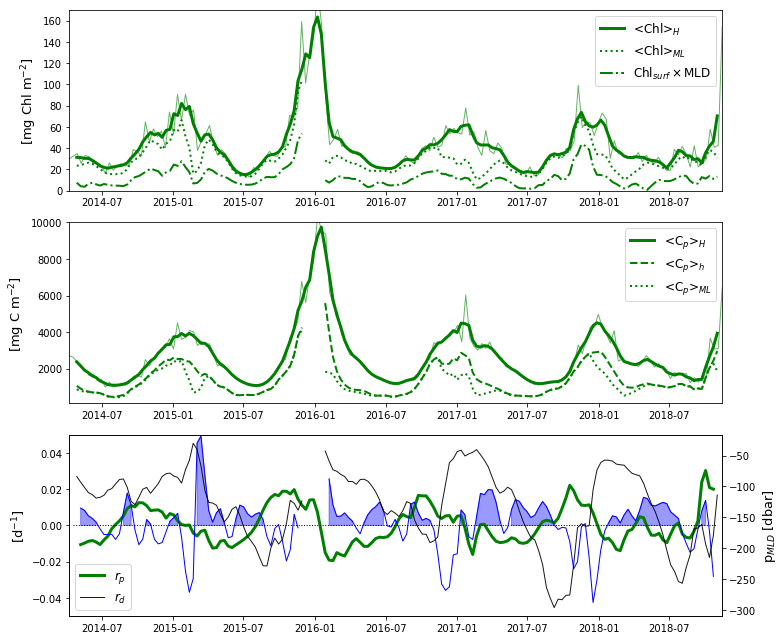

In [18]:
fig, (ax1,ax3,ax5) = plt.subplots(nrows=3, ncols=1, figsize=(11,9))
fig.set_tight_layout(True)
ax6 = ax5.twinx()

ax3.plot(CintgH.time, CintgH.where(CintgH<1.5e4).data, 'g', lw=1, alpha=.6)
ax1.plot(ChlH.time, ChlH.data, 'g', lw=1, alpha=.6)

ax1.plot(ChlH_intp.rolling(time=nroll, center=True).mean().time, 
         ChlH_intp.rolling(time=nroll, center=True).mean().data, 
         'g', lw=3, label=r"<Chl>$_H$")
ax1.plot(Chlml_intp.rolling(time=nroll, center=True).mean().time, 
         Chlml_intp.rolling(time=nroll, center=True).mean().data, 
         'g:', lw=2, label=r"<Chl>$_{ML}$")
ax1.plot(ChlsML_intp.rolling(time=nroll, center=True).mean().time, 
         ChlsML_intp.rolling(time=nroll, center=True).mean().data, 
         'g-.', lw=2, label=r"Chl$_{surf}\times$MLD")

ax3.plot(CintgH_tp.rolling(time=nroll, center=True).mean().time, 
         CintgH_tp.where(CintgH_tp<1.5e4).rolling(time=nroll, center=True).mean().data, 
         'g', lw=3, label=r"<C$_p$>$_H$")
ax3.plot(Cintg_tp.rolling(time=nroll, center=True).mean().time, 
         Cintg_tp.where(Cintg_tp<1.5e4).rolling(time=nroll, center=True).mean().data, 
         'g--', lw=2, label=r"<C$_p$>$_h$")
ax3.plot(Cml_intp.rolling(time=nroll, center=True).mean().time, 
         Cml_intp.where(Cml_intp<1.5e4).rolling(time=nroll, center=True).mean().data, 
         'g:', lw=2, label=r'<C$_p$>$_{ML}$')

ax6.plot(pML_intp.rolling(time=nroll, center=True).mean().time, 
         -pML_intp.rolling(time=nroll, center=True).mean(), 
         color='k', lw=1, alpha=.9)
ax5.plot(rPH.time.data, rPH*86400, 'g', label=r'$r_p$', lw=3)
ax5.plot(rD.time.data, rD*86400, c='b', label=r'$r_d$', lw=1)
ax5.plot(rD.time, np.zeros(len(rD.time)), 'k:', lw=1)
ax5.fill_between(np.asarray(rD_pos.time[:-1],dtype='datetime64'), rD_pos[:-1]*86400, color='b', alpha=0.4)

ax1.set_xlim([C_test.time.data[0],C_test.time.data[-1]])
ax3.set_xlim([C_test.time.data[0],C_test.time.data[-1]])
ax5.set_xlim([C_test.time.data[0],C_test.time.data[-1]])
ax1.set_ylim([0,170])
ax3.set_ylim([100,10000])
ax5.set_ylim([-.05,.05])
ax1.set_ylabel(r"[mg Chl m$^{-2}$]", fontsize=13)
ax3.set_ylabel(r"[mg C m$^{-2}$]", fontsize=13)
ax5.set_ylabel(r"[d$^{-1}$]", fontsize=13)
ax6.set_ylabel(r"p$_{MLD}$ [dbar]", fontsize=13)
ax1.legend(loc='upper right', fontsize=12)
ax3.legend(loc='upper right', fontsize=12)
ax5.legend(loc='lower left', fontsize=12)
# plt.savefig(op.join(ddir,'../Figures/SOCCOM-4185_Cphyto-r.pdf'))